In [1]:
import numpy as np
import json
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

The following function loads relevant information regarding stock performance after an article publication. The goal in our project is to predict whether a stock price will increase, decrease, or stay the same following the publication of an article about a company. The 'start_price' is the first avaible stock price after the article was published ('pub_time'). 'end_price_1days' is the price of the stock at the end of the trading day (or the following trading day if the article was published after 4pm ET). 'BUY', 'SELL', and 'HOLD' are determined as follows:
- 'BUY': If the percent increase in stock price from publication time ('start_price') to the stock price at the end of the day ('end_price_1days') is >0.5%
- 'SELL': If the percent increase in stock price from publication time ('start_price') to the stock price at the end of the day ('end_price_1days') is <-0.5%
- 'HOLD': If the percent increase in stock price from publication time ('start_price') to the stock price at the end of the day ('end_price_1days')is between -0.5, +0.5


In [2]:
def load_data_into_df(path):
    with open(path, "r") as f:
        data = json.load(f)
    id = 0

    ids = []
    tickers = []
    pub_times = []
    start_times = []
    start_price_opens = []
    end_price_1days = []
    stock_price_changes = []
    stock_price_percent_change = []
    actions = []
    for item in data:
        try:
            pub_time = item['pub_time']
            ticker = item['labels']['ticker']
            start_price = item['labels']['start_price_open']
            end_price = item['labels']['end_price_1day']
        except KeyError:
            continue # Skip any articles that have missing data

        ids.append(id)
        id += 1
        pub_times.append(pub_time)
        tickers.append(ticker)
        start_price_opens.append(start_price)
        end_price_1days.append(end_price)
        stock_price_changes.append(end_price - start_price)

        percent_change = ((end_price - start_price) / start_price)*100
        stock_price_percent_change.append(percent_change)

        if abs(percent_change) <= 0.5:
            action = 'HOLD'
        elif percent_change > 0.5:
            action = 'BUY'
        elif percent_change < -0.5:
            action = 'SELL'
        else:
            action = None

        actions.append(action)

    return pd.DataFrame.from_dict(
        {
            'id': ids,
            'pub_time': pub_times,
            'ticker': tickers,
            'start_price': start_price_opens,
            'end_price_1day': end_price_1days,
            'price_change': stock_price_changes,
            'price_change_percent': stock_price_percent_change,
            'action': actions
        }
    )

In [3]:
df = load_data_into_df('data/Trading_benchmark/evaluate_news.json')

In [4]:
df.head()

,id,pub_time,ticker,start_price,end_price_1day,price_change,price_change_percent,action
0,0,2020-12-08 09:00:00-05:00,MIK,12.07,12.80,0.73,6.048053,BUY
1,1,2020-10-01 12:11:00-04:00,DUK,89.74,90.05,0.31,0.345442,HOLD
2,2,2020-10-05 08:00:00-04:00,PLRX,20.00,21.43,1.43,7.150000,BUY
3,3,2021-02-22 06:05:00-05:00,DISH,34.25,32.00,-2.25,-6.569343,SELL
4,4,2021-01-21 07:30:00-05:00,TGT,188.35,191.00,2.65,1.406955,BUY


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106619 entries, 0 to 106618
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    106619 non-null  int64  
 1   pub_time              106619 non-null  object 
 2   ticker                106619 non-null  object 
 3   start_price           106619 non-null  float64
 4   end_price_1day        106619 non-null  float64
 5   price_change          106619 non-null  float64
 6   price_change_percent  106619 non-null  float64
 7   action                106619 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 6.5+ MB


In [6]:
df.describe()

,id,start_price,end_price_1day,price_change,price_change_percent
count,106619.000000,106619.000000,106619.000000,106619.000000,106619.000000
mean,53309.000000,77.769594,77.784219,0.014625,0.230676
std,30778.398513,156.778499,156.711596,3.381724,7.209507
min,0.000000,0.126780,0.127400,-135.010000,-75.617647
25%,26654.500000,12.310000,12.320000,-0.350000,-1.153937
50%,53309.000000,36.050000,36.050000,0.000000,0.000000
75%,79963.500000,88.405000,88.630000,0.390000,1.212121
max,106618.000000,4805.220000,4800.000000,147.750000,1293.148148


<AxesSubplot: xlabel='action', ylabel='Count'>

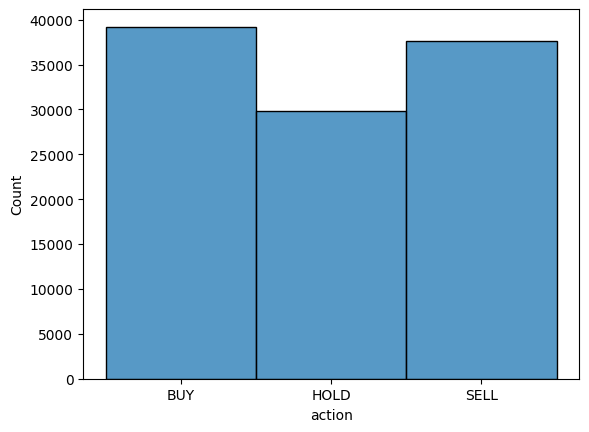

In [7]:
sns.histplot(x='action', data=df)

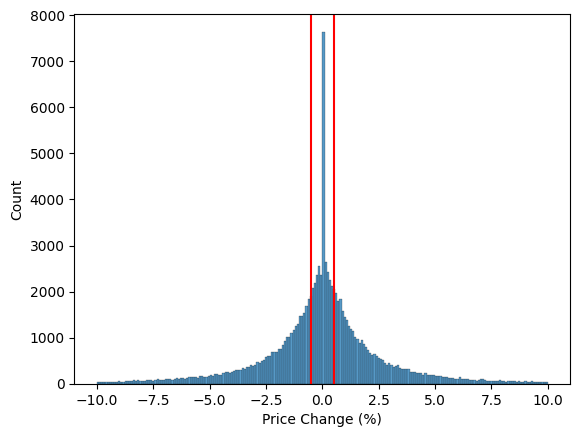

In [10]:
sns.histplot(x='price_change_percent', data=df[df['price_change_percent'].abs() < 10])
plt.xlabel('Price Change (%)')
plt.axvline(0.5, c='r')
plt.axvline(-0.5, c='r')

In [9]:
l0 = len(df)
l1 = len(df[df['price_change_percent'].abs() < 10])

print(f'{round(l1/l0*100,2)}% of the data saw stock increase/decreases within 10%')

96.16% of the data saw stock increase/decreases within 10%


In [15]:
print(len(df[df['action']=='BUY']))
print(len(df[df['action']=='SELL']))
print(len(df[df['action']=='HOLD']))

39211
37598
29810


In [16]:
print(len(df[df['price_change_percent']==0]))

5136


In [17]:
df.describe()

,id,start_price,end_price_1day,price_change,price_change_percent
count,106619.000000,106619.000000,106619.000000,106619.000000,106619.000000
mean,53309.000000,77.769594,77.784219,0.014625,0.230676
std,30778.398513,156.778499,156.711596,3.381724,7.209507
min,0.000000,0.126780,0.127400,-135.010000,-75.617647
25%,26654.500000,12.310000,12.320000,-0.350000,-1.153937
50%,53309.000000,36.050000,36.050000,0.000000,0.000000
75%,79963.500000,88.405000,88.630000,0.390000,1.212121
max,106618.000000,4805.220000,4800.000000,147.750000,1293.148148


TODO: EDA for corporate events

A 229 CT 314
RD 290 DC 109
DI 225 GI 99
NC 518 RSS 51
SD 80 SR 385

In [23]:
events.values()

dict_values([229, 290, 225, 518, 80, 314, 109, 99, 51, 385, 76])

([<matplotlib.patches.Wedge at 0x2d1c75330>,
 [Text(1.0499596935254063, 0.3280009786144472, 'A'),
  Text(0.6044598798615171, 0.9190365899341553, 'RD'),
  Text(-0.10890436118852556, 1.0945957427809225, 'DI'),
  Text(-0.970969074575845, 0.5169323516837839, 'NC'),
  Text(-1.050392476669747, -0.32661237722351455, 'SD'),
  Text(-0.7484946075808853, -0.8060743281002918, 'CT'),
  Text(-0.20674805981166713, -1.0803958717822424, 'DC'),
  Text(0.09442230718940964, -1.0959399745903189, 'GI'),
  Text(0.30850999893044473, -1.0558511166636786, 'RSS'),
  Text(0.8341753239488006, -0.7170436032173455, 'SR'),
  Text(1.0944507813842026, -0.11035165212858641, 'SS')],
 [Text(0.5727052873774943, 0.17890962469878938, '9.6%'),
  Text(0.32970538901537294, 0.50129268541863, '12.2%'),
  Text(-0.05940237883010484, 0.5970522233350486, '9.5%'),
  Text(-0.5296194952231881, 0.2819631009184276, '21.8%'),
  Text(-0.572941350910771, -0.17815220575828064, '3.4%'),
  Text(-0.4082697859532101, -0.4396769062365227, '13.2%')

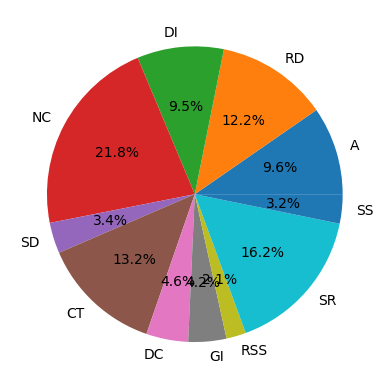

In [25]:
events = {
    'A': 229,
    'RD': 290,
    'DI': 225,
    'NC': 518,
    'SD': 80,
    'CT': 314,
    'DC': 109,
    'GI': 99,
    'RSS': 51,
    'SR': 385,
    'SS': 76
}

plt.pie(events.values(), labels=events.keys(), autopct='%1.1f%%')

([<matplotlib.patches.Wedge at 0x2d48c1180>,
 [Text(-0.9109642100810751, 0.6165583572958548, 'BUY'),
  Text(0.6141472345961865, -0.9125914607522124, 'SELL'),
  Text(1.0201200385100002, -0.411527771882234, 'HOLD')],
 [Text(-0.4968895691351318, 0.33630455852501173, '81.1%'),
  Text(0.334989400688829, -0.4977771604102976, '6.7%'),
  Text(0.5564291119145455, -0.2244696937539458, '12.2%')])

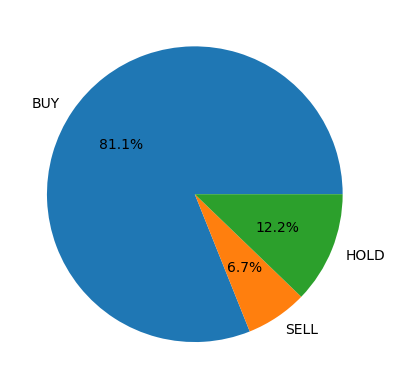

In [27]:
movements = {
    'BUY': events['A'] + events['DI'] + events['NC'] + events['SD'] + events['CT'] + events['GI'] + events['SR'] + events['SS'],
    'SELL': events['RSS'] + events['DC'],
    'HOLD': events['RD']

}

plt.pie(movements.values(), labels=movements.keys(), autopct='%1.1f%%')